**Import Packages**

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    RocCurveDisplay, PrecisionRecallDisplay, confusion_matrix, ConfusionMatrixDisplay,
    classification_report
)

**Load Data**

In [34]:
df = pd.read_csv('wallacecommunications.csv')

In [35]:
df.shape

(50662, 20)

In [36]:
df.head()

,ID,town,country,age,job,married,education,arrears,current_balance,housing,has_tv_package,last_contact,conn_tr,last_contact_this_campaign_day,last_contact_this_campaign_month,this_campaign,days_since_last_contact_previous_campaign,contacted_during_previous_campaign,outcome_previous_campaign,new_contract_this_campaign
0,32390233,Bristol,UK,39,management,married,tertiary,no,-1.90,no,yes,unknown,4,11,jun,8,-1,0,unknown,yes
1,41226029,Basildon,UK,53,housemaid,married,primary,no,3.62,no,no,cellular,1,28,jul,2,-1,0,unknown,yes
2,85498057,Blackburn,UK,79,retired,divorced,primary,no,27.87,no,no,telephone,3,13,jul,1,377,1,success,yes
3,76539627,Oldham,UK,43,services,single,secondary,no,5.50,yes,no,cellular,3,13,may,2,-1,0,unknown,no
4,76290986,Middlesbrough,UK,35,technician,single,secondary,no,3.44,no,no,cellular,2,27,aug,16,-1,0,unknown,yes


**Check Null Values**

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50662 entries, 0 to 50661
Data columns (total 20 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   ID                                         50662 non-null  int64  
 1   town                                       50662 non-null  object 
 2   country                                    50662 non-null  object 
 3   age                                        50662 non-null  int64  
 4   job                                        50662 non-null  object 
 5   married                                    50662 non-null  object 
 6   education                                  50662 non-null  object 
 7   arrears                                    50662 non-null  object 
 8   current_balance                            50662 non-null  float64
 9   housing                                    50662 non-null  object 
 10  has_tv_package        

In [38]:
df.duplicated().sum()

np.int64(0)

In [39]:
df.nunique()

,0
ID,50644
town,101
country,5
age,76
job,12
married,3
education,4
arrears,2
current_balance,6928
housing,2


In [40]:
df.describe()

,ID,age,current_balance,conn_tr,last_contact_this_campaign_day,this_campaign,days_since_last_contact_previous_campaign,contacted_during_previous_campaign
count,5.066200e+04,50662.000000,50662.000000,50662.000000,50662.000000,50662.000000,50662.000000,50662.000000
mean,5.502871e+07,40.979373,13.991210,3.005093,15.768525,2.713217,42.644408,0.640283
std,2.598596e+07,10.919324,30.899163,1.409003,8.347083,3.052227,102.238078,2.358029
min,1.000073e+07,18.000000,-80.190000,1.000000,1.000000,1.000000,-1.000000,0.000000
25%,3.249964e+07,32.000000,0.820000,2.000000,8.000000,1.000000,-1.000000,0.000000
50%,5.501127e+07,39.000000,4.720000,3.000000,16.000000,2.000000,-1.000000,0.000000
75%,7.748809e+07,48.000000,14.950000,4.000000,21.000000,3.000000,-1.000000,0.000000
max,9.999952e+07,95.000000,984.170000,5.000000,31.000000,63.000000,871.000000,275.000000


**Check Data Types**

In [41]:
categorical_cols = []
for col in df.columns:
    if df[col].dtype == 'object':
        categorical_cols.append(col)

print("Categorical colomns: ", categorical_cols)


numerical_cols = []
for col in df.columns:
    if col not in categorical_cols:
        numerical_cols.append(col)

print("Numerical colomns: ", numerical_cols)

Categorical colomns:  ['town', 'country', 'job', 'married', 'education', 'arrears', 'housing', 'has_tv_package', 'last_contact', 'last_contact_this_campaign_month', 'outcome_previous_campaign', 'new_contract_this_campaign']
Numerical colomns:  ['ID', 'age', 'current_balance', 'conn_tr', 'last_contact_this_campaign_day', 'this_campaign', 'days_since_last_contact_previous_campaign', 'contacted_during_previous_campaign']


**Target Label Encoding**

In [42]:
df["new_contract_this_campaign"] = df["new_contract_this_campaign"].map({'yes': 1, 'no': 0})

**Features / Target Split**

In [43]:
X = df.drop("new_contract_this_campaign", axis = 'columns')
y = df["new_contract_this_campaign"]
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (50662, 19), y shape: (50662,)


**Target Balance**

In [44]:
print("Class balance (counts):\n", y.value_counts())

Class balance (counts):
 new_contract_this_campaign
0    40763
1     9899
Name: count, dtype: int64


In [45]:
df.head()

,ID,town,country,age,job,married,education,arrears,current_balance,housing,has_tv_package,last_contact,conn_tr,last_contact_this_campaign_day,last_contact_this_campaign_month,this_campaign,days_since_last_contact_previous_campaign,contacted_during_previous_campaign,outcome_previous_campaign,new_contract_this_campaign
0,32390233,Bristol,UK,39,management,married,tertiary,no,-1.90,no,yes,unknown,4,11,jun,8,-1,0,unknown,1
1,41226029,Basildon,UK,53,housemaid,married,primary,no,3.62,no,no,cellular,1,28,jul,2,-1,0,unknown,1
2,85498057,Blackburn,UK,79,retired,divorced,primary,no,27.87,no,no,telephone,3,13,jul,1,377,1,success,1
3,76539627,Oldham,UK,43,services,single,secondary,no,5.50,yes,no,cellular,3,13,may,2,-1,0,unknown,0
4,76290986,Middlesbrough,UK,35,technician,single,secondary,no,3.44,no,no,cellular,2,27,aug,16,-1,0,unknown,1


**Train/Test Split**

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

In [47]:
categorical_cols = []
for col in X.columns:
    if X[col].dtype == 'object':
        categorical_cols.append(col)

print("Categorical colomns: ", categorical_cols)


numerical_cols = []
for col in X.columns:
    if col not in categorical_cols:
        numerical_cols.append(col)

print("Numerical colomns: ", numerical_cols)

Categorical colomns:  ['town', 'country', 'job', 'married', 'education', 'arrears', 'housing', 'has_tv_package', 'last_contact', 'last_contact_this_campaign_month', 'outcome_previous_campaign']
Numerical colomns:  ['ID', 'age', 'current_balance', 'conn_tr', 'last_contact_this_campaign_day', 'this_campaign', 'days_since_last_contact_previous_campaign', 'contacted_during_previous_campaign']


**Report**

In [48]:
def report(name, y_true, y_pred, y_proba):
    target_names = ["No", "Yes"]
    acc = accuracy_score(y_true, y_pred)
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    roc = roc_auc_score(y_true, y_proba)
    print(f"=== {name} ===")
    print(f"Accuracy: {acc:.3f} | Precision: {pr:.3f} | Recall: {rc:.3f} | F1: {f1:.3f} | ROC AUC: {roc:.3f}")
    print(classification_report(y_true, y_pred, target_names=target_names))
    return acc, pr, rc, f1, roc

**Logistic Regression**

In [49]:
num_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(drop='first', handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_transformer, numerical_cols),
    ("cat", categorical_transformer, categorical_cols)
])

pipe_lr = Pipeline([
    ('preprocessor',preprocessor),
    ("clf", LogisticRegression(max_iter=500, random_state=42))
])

pipe_lr.fit(X_train, y_train)

y_pred_lr  = pipe_lr.predict(X_test)

y_proba_lr  = pipe_lr.predict_proba(X_test)[:, 1]

metrics_lr  = report("Logistic Regression (baseline)", y_test, y_pred_lr, y_proba_lr)

=== Logistic Regression (baseline) ===
Accuracy: 0.837 | Precision: 0.711 | Recall: 0.283 | F1: 0.405 | ROC AUC: 0.767
              precision    recall  f1-score   support

          No       0.85      0.97      0.91     10191
         Yes       0.71      0.28      0.40      2475

    accuracy                           0.84     12666
   macro avg       0.78      0.63      0.66     12666
weighted avg       0.82      0.84      0.81     12666



/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


<Figure size 1000x400 with 0 Axes>

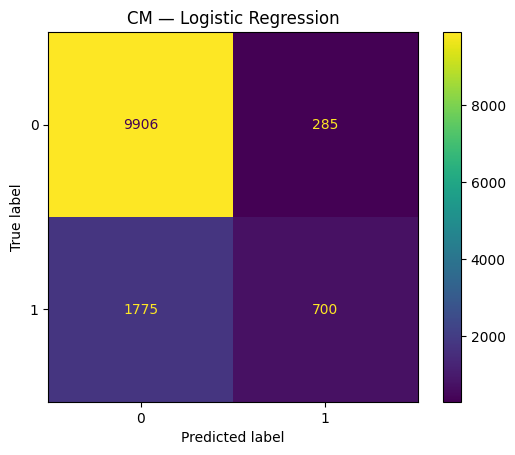

<Figure size 600x500 with 0 Axes>

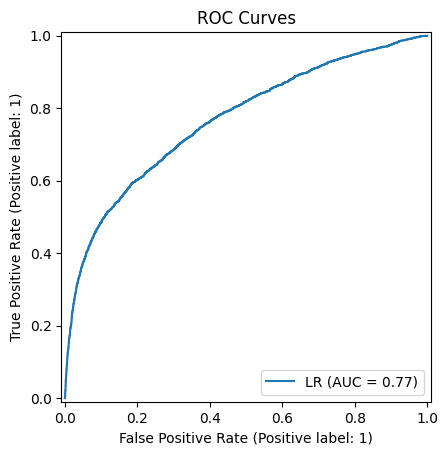

<Figure size 600x500 with 0 Axes>

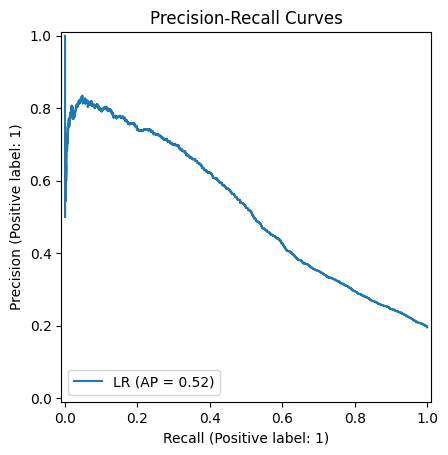

In [50]:
fig = plt.figure(figsize=(10, 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr);
plt.title("CM — Logistic Regression");
plt.show()

fig = plt.figure(figsize=(6, 5))
RocCurveDisplay.from_predictions(y_test, y_proba_lr, name="LR")
plt.title("ROC Curves")
plt.show()

fig = plt.figure(figsize=(6, 5))
PrecisionRecallDisplay.from_predictions(y_test, y_proba_lr, name="LR")
plt.title("Precision-Recall Curves")
plt.show()

In [51]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_lr  = cross_val_score(pipe_lr,  X, y, cv=cv, scoring="accuracy")

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [52]:
print(f"LR CV Accuracy:  mean={cv_lr.mean():.3f} ± {cv_lr.std():.3f}")

LR CV Accuracy:  mean=0.836 ± 0.002


In [53]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

if "cv" not in globals():
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_lr = {
    "clf__solver": ["lbfgs", "liblinear"],
    "clf__penalty": ["l2"],
    "clf__C": [0.01, 0.1, 1.0, 3.0, 10.0],
    "clf__max_iter": [5000],
}

# Grid searches (5-fold CV, AUC focus)
gs_lr = GridSearchCV(
    estimator=pipe_lr,
    param_grid=grid_lr,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=0,
)
gs_lr.fit(X_train, y_train)

print("Best LR params:", gs_lr.best_params_, "AUC:", gs_lr.best_score_)

best_lr  = gs_lr.best_estimator_

Best LR params: {'clf__C': 0.1, 'clf__max_iter': 5000, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'} AUC: 0.7649304762915395


In [54]:
y_pred_lr_best  = best_lr.predict(X_test)
y_proba_lr_best  = best_lr.predict_proba(X_test)[:, 1]

print("\n== Tuned Logistic Regression ==")
_ = report("LR (tuned)", y_test, y_pred_lr_best, y_proba_lr_best)


== Tuned Logistic Regression ==
=== LR (tuned) ===
Accuracy: 0.837 | Precision: 0.712 | Recall: 0.275 | F1: 0.397 | ROC AUC: 0.768
              precision    recall  f1-score   support

          No       0.85      0.97      0.91     10191
         Yes       0.71      0.28      0.40      2475

    accuracy                           0.84     12666
   macro avg       0.78      0.62      0.65     12666
weighted avg       0.82      0.84      0.81     12666



/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


**Random Forest**

In [55]:
preprocessor = ColumnTransformer([
    ("num", 'passthrough', numerical_cols),
    ("cat", categorical_transformer, categorical_cols)
])

pipe_rf = Pipeline([
    ('preprocessor',preprocessor),
    ("clf", RandomForestClassifier(class_weight='balanced', random_state=42))
])

pipe_rf.fit(X_train, y_train)

y_pred_rf = pipe_rf.predict(X_test)
y_proba_rf = pipe_rf.predict_proba(X_test)[:,1]

metrics_rf  = report("Random Forest (baseline)", y_test, y_pred_rf, y_proba_rf)

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


=== Random Forest (baseline) ===
Accuracy: 0.868 | Precision: 0.791 | Recall: 0.442 | F1: 0.567 | ROC AUC: 0.885
              precision    recall  f1-score   support

          No       0.88      0.97      0.92     10191
         Yes       0.79      0.44      0.57      2475

    accuracy                           0.87     12666
   macro avg       0.83      0.71      0.74     12666
weighted avg       0.86      0.87      0.85     12666



<Figure size 1000x400 with 0 Axes>

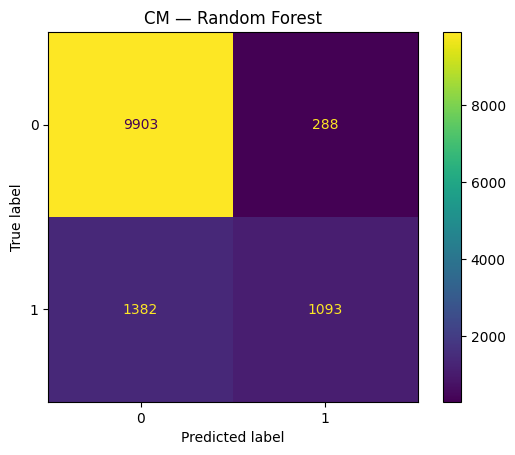

<Figure size 600x500 with 0 Axes>

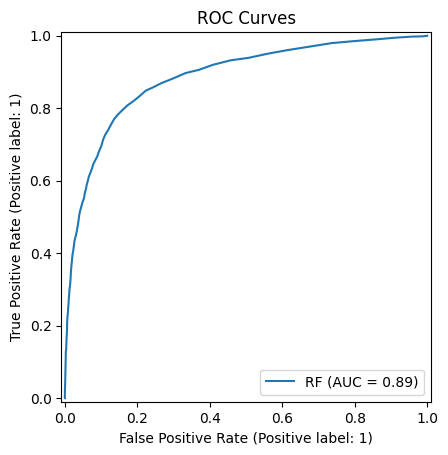

<Figure size 600x500 with 0 Axes>

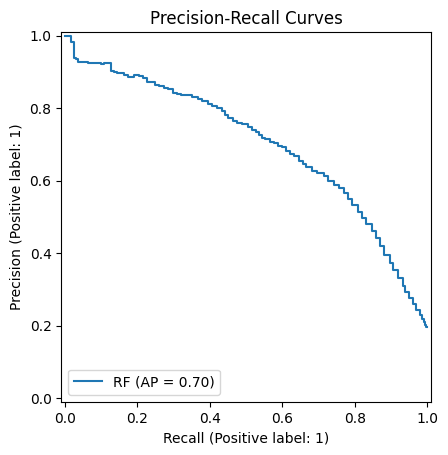

In [56]:
fig = plt.figure(figsize=(10, 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf);
plt.title("CM — Random Forest");
plt.show()

fig = plt.figure(figsize=(6, 5))
RocCurveDisplay.from_predictions(y_test, y_proba_rf, name="RF")
plt.title("ROC Curves")
plt.show()

fig = plt.figure(figsize=(6, 5))
PrecisionRecallDisplay.from_predictions(y_test, y_proba_rf, name="RF")
plt.title("Precision-Recall Curves")
plt.show()

In [57]:
cv_rf  = cross_val_score(pipe_rf,  X, y, cv=cv, scoring="accuracy")

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [58]:
print(f"RF CV Accuracy:  mean={cv_rf.mean():.3f} ± {cv_rf.std():.3f}")

RF CV Accuracy:  mean=0.868 ± 0.003


In [32]:
rf_param_dist = {
    "clf__n_estimators": [50, 100, 200],
    "clf__max_depth": [None, 10, 20, 30],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__max_features": ["sqrt", "log2", None],
    "clf__bootstrap": [True, False],
    "clf__class_weight": [None, "balanced"]
}

gs_rf = RandomizedSearchCV(
    estimator=pipe_rf,
    param_distributions=rf_param_dist,
    n_iter=30,
    scoring="roc_auc",
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

gs_rf.fit(X_train, y_train)

In [ ]:
print("Best RF params:", gs_rf.best_params_, "AUC:", gs_rf.best_score_)

In [ ]:
best_rf  = gs_rf.best_estimator_

y_pred_rf_best  = best_rf.predict(X_test)
y_proba_rf_best  = best_rf.predict_proba(X_test)[:, 1]

print("\n== Tuned Random Forest ==")
_ = report("RF (tuned)", y_test, y_pred_rf_best, y_proba_rf_best)

**LightGBM**

In [59]:
preprocessor = ColumnTransformer([
    ("num", 'passthrough', numerical_cols),
    ("cat", categorical_transformer, categorical_cols)
])

pipe_lgbm = Pipeline([
    ('preprocessor',preprocessor),
    ("clf", RandomForestClassifier(class_weight='balanced', random_state=42))
])

pipe_lgbm.fit(X_train, y_train)

y_pred_lgbm = pipe_lgbm.predict(X_test)
y_proba_lgbm = pipe_lgbm.predict_proba(X_test)[:,1]

metrics_lgbm  = report("Logistic Regression (baseline)", y_test, y_pred_lr, y_proba_lr)

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


=== Logistic Regression (baseline) ===
Accuracy: 0.837 | Precision: 0.711 | Recall: 0.283 | F1: 0.405 | ROC AUC: 0.767
              precision    recall  f1-score   support

          No       0.85      0.97      0.91     10191
         Yes       0.71      0.28      0.40      2475

    accuracy                           0.84     12666
   macro avg       0.78      0.63      0.66     12666
weighted avg       0.82      0.84      0.81     12666



<Figure size 1000x400 with 0 Axes>

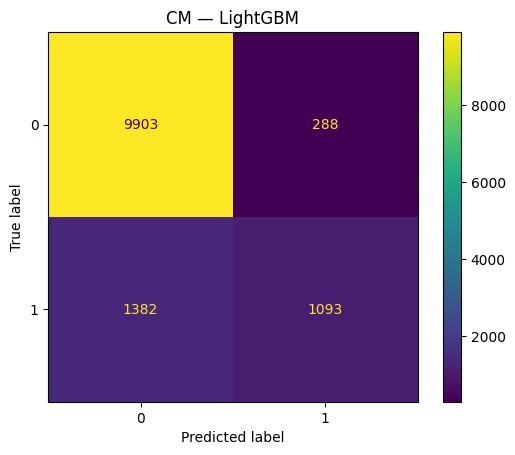

<Figure size 600x500 with 0 Axes>

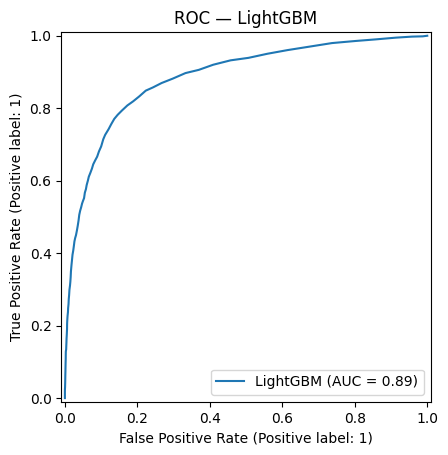

<Figure size 600x500 with 0 Axes>

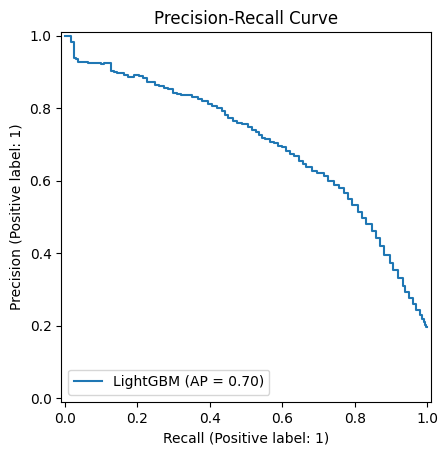

In [60]:
fig = plt.figure(figsize=(10, 4));
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lgbm);
plt.title("CM — LightGBM");
plt.show()

fig = plt.figure(figsize=(6, 5));
RocCurveDisplay.from_predictions(y_test, y_proba_lgbm, name="LightGBM")
plt.title("ROC — LightGBM");
plt.show()

fig = plt.figure(figsize=(6, 5))
PrecisionRecallDisplay.from_predictions(y_test, y_proba_lgbm, name="LightGBM")
plt.title("Precision-Recall Curve")
plt.show()

In [61]:
cv_lgbm  = cross_val_score(pipe_lgbm,  X, y, cv=cv, scoring="accuracy")

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [62]:
print(f"LightGBM CV Accuracy:  mean={cv_lgbm.mean():.3f} ± {cv_lgbm.std():.3f}")

LightGBM CV Accuracy:  mean=0.868 ± 0.003
